In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from persim import plot_diagrams

from astropology.plasticc import lcs_from_plasticc
from astropology.constants import CLASSES, PASSBANDS

In [2]:
data_directory = "/home/edgar/astropology/data/"

plasticc = pd.read_csv(
    f"{data_directory}/plasticc_train_lightcurves.csv.gz",
)
meta_data = pd.read_csv(
    f"{data_directory}/plasticc_train_metadata.csv.gz",
    index_col="object_id"
)

In [3]:
g_lcs, mjds = lcs_from_plasticc(raw_df=plasticc, passband="g")

### Deep Drilling Fields (DDF) Vs Wide-Fast-Deep (WFD) light curves
The DDF field samples a patch of the sky with more exposure time than for the WDF approach

In [4]:
# get unique identifiers
mask_ddf = meta_data["ddf_bool"].to_numpy() == True

ddf_object_ids = meta_data.index[mask_ddf].to_numpy()
wfd_object_ids = meta_data.index[~mask_ddf].to_numpy()


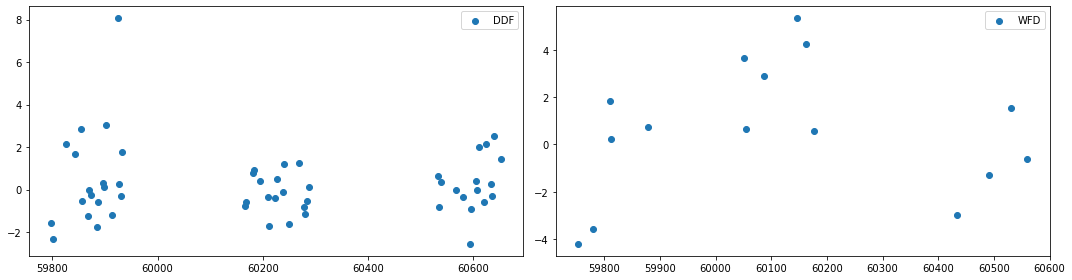

In [5]:
fig, axs = plt.subplots(
    tight_layout=True, nrows=1, ncols=2, figsize=(15, 4)
)

idx_ddf = ddf_object_ids[5]
axs[0].scatter(mjds[idx_ddf], g_lcs[idx_ddf], label="DDF")

idx_wfd = wfd_object_ids[5]
axs[1].scatter(mjds[idx_wfd], g_lcs[idx_wfd], label="WFD")

for ax in axs: ax.legend()

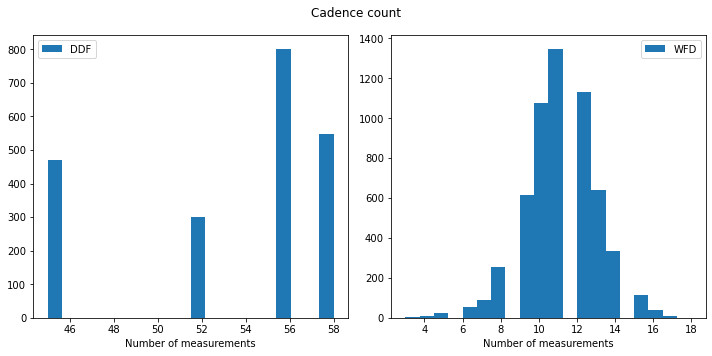

In [6]:
cadence_ddf = np.empty(ddf_object_ids.size)
cadence_wfd = np.empty(wfd_object_ids.size)

for idx, object_id in enumerate(ddf_object_ids):

    cadence_ddf[idx] = g_lcs[object_id].size

for idx, object_id in enumerate(wfd_object_ids):

    cadence_wfd[idx] = g_lcs[object_id].size

fig, axs = plt.subplots(
    tight_layout=True, nrows=1, ncols=2, figsize=(10, 5)
)

fig.suptitle("Cadence count")

n_bins = 20

_ = axs[0].hist(cadence_ddf, bins=n_bins, label="DDF")
axs[0].set_xlabel("Number of measurements")

_ = axs[1].hist(cadence_wfd, bins=n_bins, label="WFD")
axs[1].set_xlabel("Number of measurements")

for ax in axs: ax.legend()

### Detected vs no detected